# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as st

In [2]:
df = pd.read_csv('data/human_body_temperature.csv')
df.head()

temperature gender  heart_rate
0         99.3      F        68.0
1         98.4      F        81.0
2         97.8      M        73.0
3         99.2      F        66.0
4         98.0      F        73.0

In [3]:
# Setting seaborn
sns.set()

### 1. Is the distribution of body temperatures normal?

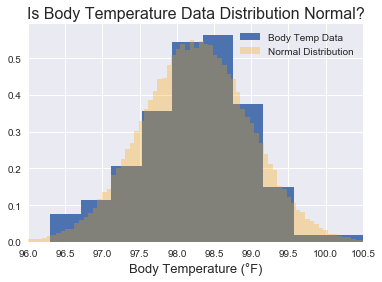

In [4]:
temp = df.temperature
n_bins = int(np.sqrt(len(temp)))
sample_norm = np.random.normal(98.249, 0.733, size=100000)

_ = plt.hist(temp, bins=n_bins, normed=True, label='Body Temp Data')
_ = plt.hist(sample_norm, bins=100, normed=True, alpha=0.3, label='Normal Distribution', color='orange')
_ = plt.xlabel('Body Temperature (°F)', fontsize=13)
_ = plt.xlim(96, 100.5)
_ = plt.legend(loc='upper right')
_ = plt.title('Is Body Temperature Data Distribution Normal?', fontsize=16)
plt.show()

In [5]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    
    # Number of data points: n
    n = len(data)
    
    # x-data for the ECDF: x
    x = np.sort(data)
    
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    
    return x, y

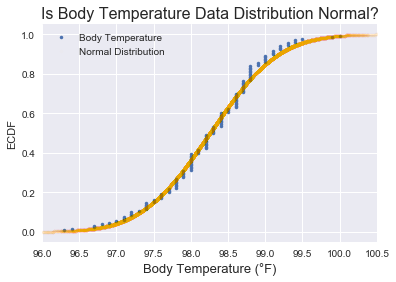

In [6]:
# Compute and plot ECDF
x_temp, y_temp = ecdf(temp)
x_norm, y_norm = ecdf(sample_norm)

_ = plt.plot(x_temp, y_temp, marker='.', linestyle='none', label='Body Temperature')
_ = plt.plot(x_norm, y_norm, marker='.', linestyle='none', color='orange', alpha=0.01, label='Normal Distribution')

_ = plt.xlabel('Body Temperature (°F)', fontsize=13)
_ = plt.ylabel('ECDF')
_ = plt.xlim(96, 100.5)
_ = plt.legend(loc='upper left')
_ = plt.title('Is Body Temperature Data Distribution Normal?', fontsize=16)

# Display the plot
plt.show()

> As you can see from the graphs, the distribution of the Body Temperature data looks normal.

### 2. Is the sample size large? Are the observations independent?

In [7]:
print("The sample size for temperature data is %d data points." % df.temperature.size)

The sample size for temperature data is 130 data points.


> Sample size is relatively large with 130 data points.

> Since this sample size is greater than 30, the observations can be assumed to be independent.

### 3. Is the true population mean really 98.6 degrees F?

In [8]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates for function."""
    
    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)
    
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, size=len(data)))
    
    return bs_replicates

>Would you use a one-sample or two-sample test? Why?
* One-Sample test b/c we have one data sample to compare to the value of 98.6 degrees F.
* Null hypothesis to test: True mean is equal to 98.6 degrees F.

In [10]:
mean_temp = np.mean(temp)

# Shifting the reported data to hypothesis that the real mean is 98.6 degrees F
temp_shifted = temp - mean_temp + 98.6

def diff_from_real(data):
    return np.mean(data) - 98.6

diff_obs = diff_from_real(temp)

# Drawing bootstrap replicates for difference of mean to 98.6 to get p value
bs_replicates = draw_bs_reps(temp_shifted, diff_from_real, 10000)
p = np.sum(bs_replicates <= diff_obs) / 10000

# Print the p-value
print('p = %f' % p)

p = 0.000000


> In this situation, is it appropriate to use the  t  or  z  statistic?
> * Since the sample size is large, z statistic is appropriate.

In [11]:
temp_z = st.norm.ppf(p)
temp_t = st.t.ppf(p, 10)

print('Z: %.3f ; T: %.3f' % (temp_z, temp_t))

Z: -inf ; T: -inf


> Now try using the other test. How is the result different? Why?
> * Since the p-value is 0 for this case, the t statistic will be the same as the z statistic.

### 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

In [12]:
small_sample = temp[:10]
small_sample

0    99.3
1    98.4
2    97.8
3    99.2
4    98.0
5    99.2
6    98.0
7    98.8
8    98.4
9    98.6
Name: temperature, dtype: float64

In [13]:
small_mean_temp = np.mean(small_sample)

# Shifting the reported data to hypothesis that the real mean is 98.6 degrees F
small_temp_shifted = small_sample - small_mean_temp + 98.6

diff_obs_small_temp = diff_from_real(small_mean_temp)

# Drawing bootstrap replicates for difference of mean to 98.6 to get p value
bs_replicates_small_temp = draw_bs_reps(small_temp_shifted, diff_from_real, 10000)
p_small_temp = np.sum(bs_replicates_small_temp <= diff_obs_small_temp) / 10000

# Print the p-value
print('p = %f' % p_small_temp)

p = 0.419900


In [14]:
small_temp_z = st.norm.ppf(p_small_temp)
small_temp_t = st.t.ppf(p_small_temp, 10)
print('Z = %f' % small_temp_z)
print('T = %f' % small_temp_t)

Z = -0.202149
T = -0.207479


### 5. At what temperature should we consider someone's temperature to be "abnormal"?

In [15]:
bs_reps_temp = draw_bs_reps(temp, np.mean, size=10000)
conf_int_temp = np.percentile(temp, [2.5, 97.5])
print("""
Body Temp:  mean = {0:.3f} °F, 95% Conf. Int. = [{1:.1f}, {2:.1f}] °F.
""".format(mean_temp, *conf_int_temp))


Body Temp:  mean = 98.249 °F, 95% Conf. Int. = [96.7, 99.5] °F.



> Considering the 95% confidence interval to be between 96.7°F and 99.5°F, anything outside of this range could be considered "abnormal".

### 6. Is there a significant difference between males and females in normal temperature?
* Null hypothesis: Males and females have the same mean body temperature.

In [16]:
male = df[df.gender == 'M'].temperature
female = df[df.gender == 'F'].temperature

In [17]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""
    
    diff = np.mean(data_1) - np.mean(data_2)
    
    return diff

In [18]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [19]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""
    
    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)
    
    for i in range(size):
        
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        
        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    
    return perm_replicates

In [20]:
# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(male, female)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(male, female,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

p-value = 0.9898


> Cannot reject null hypothesis that male and female body temperature are the same. According to the high p value, it can be assumed that male and female body temperature is the same.

> What testing approach did you use and why?
 * Permutation test that the distribution of male and female body temperatures are identical.
 * This is more exact than bootstrapping since it utilizes the exact data.

### Conclusion

> According to the data, it can be concluded that the mean normal body temperature held to be 37°C or 98.6°F for more than 120 years is statistically incorrect.